In [2]:
%config InlineBackend.figure_formats = ['svg']
import quimb as qu
import quimb.tensor as qtn
import numpy as np

In [ ]:
from quimb import *
from quimb.tensor import *

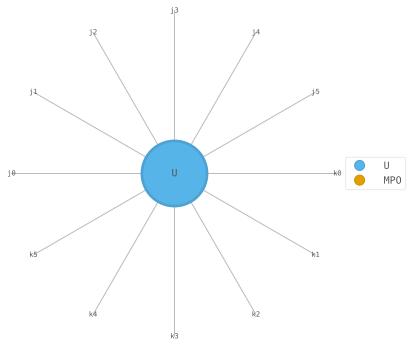

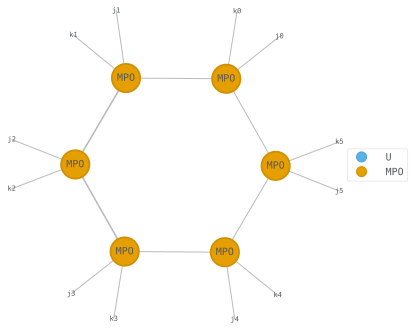

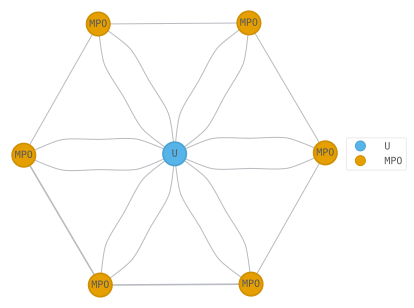

In [3]:
n = 6
gate2 = 'CZ'

# the hamiltonian
H = qu.ham_ising(n, jz=1.0, bx=0.7, cyclic=False)

# the propagator for the hamiltonian
t = 2
U_dense = qu.expm(-1j * t * H)

# 'tensorized' version of the unitary propagator
U = qtn.Tensor(
    data=U_dense.reshape([2] * (2 * n)),
    inds=[f'j{i}' for i in range(n)] + [f'k{i}' for i in range(n)],
    tags={'U'}
)
U.draw(color=[ 'U','MPO'])

chi = [2,2,3,3,2,2]

d = 2
tn_guess = qtn.TensorNetwork([
    qtn.Tensor((np.random.randn(d, d, chi[0], chi[1]) + 1j*np.random.randn(d, d, chi[0], chi[1]))/np.sqrt(2), inds=(f'j{0}',f'k{0}',f'l{0}',f'l{1}' ),tags={'MPO'}),
    qtn.Tensor((np.random.randn(d, d, chi[1], chi[2]) + 1j*np.random.randn(d, d, chi[1], chi[2]))/np.sqrt(2), inds=(f'j{1}',f'k{1}',f'l{1}',f'l{2}' ),tags={'MPO'}),
    qtn.Tensor((np.random.randn(d, d, chi[2], chi[3]) + 1j*np.random.randn(d, d, chi[2], chi[3]))/np.sqrt(2), inds=(f'j{2}',f'k{2}',f'l{2}',f'l{3}' ),tags={'MPO'}),
    qtn.Tensor((np.random.randn(d, d, chi[3], chi[4]) + 1j*np.random.randn(d, d, chi[3], chi[4]))/np.sqrt(2), inds=(f'j{3}',f'k{3}',f'l{3}',f'l{4}' ),tags={'MPO'}),
    qtn.Tensor((np.random.randn(d, d, chi[4], chi[5]) + 1j*np.random.randn(d, d, chi[4], chi[5]))/np.sqrt(2), inds=(f'j{4}',f'k{4}',f'l{4}',f'l{5}' ),tags={'MPO'}),
    qtn.Tensor((np.random.randn(d, d, chi[5], chi[0]) + 1j*np.random.randn(d, d, chi[5], chi[0]))/np.sqrt(2), inds=(f'j{5}',f'k{5}',f'l{5}',f'l{0}' ),tags={'MPO'})
])
tn_guess.draw(color=[ 'U','MPO'])

(tn_guess.H & U).draw(color=['U','MPO'])

In [8]:
dmrg=qtn.DMRG2(tn_guess)

AttributeError: 'TensorNetwork' object has no attribute 'L'

In [4]:
Utest = tn_guess.get_params()

In [72]:
Utest[0].shape

(2, 2, 2, 2)

In [38]:
def normalize_op(mpo):
    mpo /= mpo.norm()
    return mpo

def negative_overlap(mpo, U):
    return - abs((mpo.H & U).contract(all, optimize='auto-hq')) / (mpo.norm() * U.norm()) #(mpo.H @ u_target)  # minus so as to minimize  

def loss(V, U):
    return 1 - abs((V.H & U).contract(all, optimize='auto-hq')) / (V.norm() * U.norm())

In [40]:
2**n
U.norm()

7.999999999999998

In [45]:
loss(tn_guess, U)


0.9940110680742279

In [28]:
U.dtype

dtype('complex128')

In [37]:
optmzr = qtn.TNOptimizer(
    tn_guess.astype_(U.dtype),                           # our initial input, the tensors of which to optimize
    loss_fn = negative_overlap,
    norm_fn = normalize_op,
    loss_constants={'U': U},            # this is a constant TN to supply to loss_fn
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='adam',                   # supplied to scipy.minimize ex: 'L-BFGS-B'
)
mpo_opt = optmzr.optimize(100)

  0%|          | 0/100 [00:00<?, ?it/s]


TypeError: `x` and `y` must have the same dtype, got tf.float64 != tf.complex128.

In [39]:
tnoptmzr = qtn.TNOptimizer(
    tn_guess.astype_(U.dtype),# the tensor network we want to optimize
    loss,                     # the function we want to minimize
    loss_constants={'U': U},  # supply U to the loss function as a constant TN
    tags=['MPO'],             # only optimize U3 tensors
    autodiff_backend='tensorflow',   # use 'autograd' for non-compiled optimization
    optimizer='adam',     # the optimization algorithm
)

# allow 10 hops with 500 steps in each 'basin'
tn_opt = tnoptmzr.optimize_basinhopping(n=500, nhop=10)

  0%|          | 0/5000 [00:00<?, ?it/s]


TypeError: `x` and `y` must have the same dtype, got tf.float64 != tf.complex128.

In [20]:
tn_opt_dense = tn_opt.to_dense([f'j{i}' for i in range(n)], [f'k{i}' for i in range(n)])

psi0 = qu.rand_ket(2**n)

# this is the exact state we want
psif_exact = U_dense @ psi0

# this is the state our circuit will produce if fed `psi0`
psif_apprx = tn_opt_dense @ psi0

f"Fidelity: {100 * qu.fidelity(psif_apprx, psif_exact):.2f} %"

'Fidelity: 1667.32 %'